<a href="https://colab.research.google.com/github/Filocava99/CO-prediction/blob/main/Predizione_di_CO_nell'aria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predizione di CO nell'aria
Lo scopo di questo studio è quello di predire la quantità di CO in un mg/m^3 d'aria in un istante di tempo data la presenza di altri elementi chimici correlati.

## Caricamento delle librerie necessarie
Per cominciare importiamo le librerie necessarie per l'elaborazione dei dati:
* **NumPy:** necessaria per eseguire operazione su vettori e matrici di N dimensioni
* **Pandas:** per il caricamento e la gestione di dati sotto forma di tabelle
* **matplotlib:** fornisce funzioni per la creazione di diversi tipi di gravici

Dopo aver importanto le varie librerie abilitiamo la creazione dei grafici direttamente sul notebook usando l'istruzione *%matplotlib inline*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Caricamento del dataset
Procediamo caricando il dataset in un dataframe di pandas. Il dataset viene sotto forma di zip per poi venire estratto usando il modulo zipfile.

In [ ]:
import os.path
file_zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
file_zip_name = "AirQualityUCI.zip"
file_data_name = "AirQualityUCI.csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

file = "/content/" + file_data_name;

airQuality = pd.read_csv(file,sep=";");

In [ ]:
airQuality.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN
5,10/03/2004,23.00.00,"1,2",1197.0,38.0,"4,7",750.0,89.0,1337.0,96.0,1393.0,949.0,"11,2","59,2","0,7848",NaN,NaN
6,11/03/2004,00.00.00,"1,2",1185.0,31.0,"3,6",690.0,62.0,1462.0,77.0,1333.0,733.0,"11,3","56,8","0,7603",NaN,NaN
7,11/03/2004,01.00.00,1,1136.0,31.0,"3,3",672.0,62.0,1453.0,76.0,1333.0,730.0,"10,7","60,0","0,7702",NaN,NaN
8,11/03/2004,02.00.00,"0,9",1094.0,24.0,"2,3",609.0,45.0,1579.0,60.0,1276.0,620.0,"10,7","59,7","0,7648",NaN,NaN
9,11/03/2004,03.00.00,"0,6",1010.0,19.0,"1,7",561.0,-200.0,1705.0,-200.0,1235.0,501.0,"10,3","60,2","0,7517",NaN,NaN


Ci accorgiamo che il dataset contiene due colonne prive di significato, quindi procediamo a rimuoverle.

In [ ]:
airQuality.drop(["Unnamed: 15","Unnamed: 16"], axis= 1, inplace=True)

Analizziamo ora com'è strutturato il dataset:

In [ ]:
airQuality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


Le colonne del datafrane hanno il seguente significato:
* Date: la data in cui è stata effettuata la rilevazione dei dati
* Time: l'orario della rilevazione
* CO(GT): Quantità di CO in mg/m^3 misurata ogni ora
* PT08.S1(CO): valore del sensore ad ossido di stagno rappresentante il valore nominale previsto di CO
* NMHC(GT): idrocarburi non metanici presenti in un microg/m^3
* C6H6(GT): concentrazione di benzene in un microg/m^3
* PT08.S2(NMHC): valore del sensore in titanio rappresentante il valore nominale previsto di NMHC
* NOx(GT): concentrazione di NOx in ppb
* PT08.S3(NOx): valore del sensore in ossido di tungsteno rappresentante il valore nominale previsto di NOx
* NO2(GT): concentrazione di NO2 in un microg/m^3
* PT08.S4(NO2): valore del sensore in ossido di tungsteno rappresentante il valore nominale previsto di NO2
* PT08.S5(O3): valore del sensore in ossido di indio rappresentante il valore nominale previsto di O3
* T: temperatura media durante la rilevazione
* RH: umidità relativa
* AH: umidità assoluta

Le colonne PT08.** contengono valori misurati da sensori che reagiscono alla presenza di specifici elementi chimici e permettono di stimare una possibile quantià di tale elemento, tuttavia da soli non sufficienti a dare una predizione esatta, per tanto utilizzeremo modelli di regressione lineare e polinomiale.

Ci accorgiamo anche che alcuni campi, sebbene contengano valori numerici, vengono considerati come object; questo avviene poichè utilizzano il formato decimale con la virgola al posta del punto.  
Per correggere è sufficiente sostituire i punti con la virgola e viceversa e poi usare il metodo di pandas *to_numeric* per convertire tutte le stringhe numeriche in numeri.  
Per sprecare meno spazio in memoria possiamo convertire la colonna Time in una colonna di tipo categorico; questo tornerà utile per poter effettuare la regressione usando anche questa colonna.

In [ ]:
airQuality["CO(GT)"] = airQuality["CO(GT)"].str.replace(",",".",regex=False)
airQuality["C6H6(GT)"] = airQuality["C6H6(GT)"].str.replace(",",".",regex=False)
airQuality["T"] = airQuality["T"].str.replace(",",".",regex=False)
airQuality["RH"] = airQuality["RH"].str.replace(",",".",regex=False)
airQuality["AH"] = airQuality["AH"].str.replace(",",".",regex=False)
airQuality = airQuality.apply(pd.to_numeric, errors='ignore')
airQuality['Time'] = pd.Categorical(airQuality['Time'], categories=["00.00.00","01.00.00","02.00.00","03.00.00","04.00.00","05.00.00","06.00.00","07.00.00","08.00.00","09.00.00","10.00.00","11.00.00","12.00.00","13.00.00","14.00.00","15.00.00","16.00.00","17.00.00","18.00.00",
                                                                    "19.00.00","20.00.00","21.00.00","22.00.00","23.00.00"], ordered=True)
airQuality.sort_values('Time',inplace=True)

## Analisi preliminare
Ora che il nostro dataset è stato caricato correttamente possiamo effettuare un'analisi preliminare.

In [ ]:
airQuality.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


Quando in una rilevazione un valore è mancante viene assegnato -200.0; poichè non è possibile in nessun modo ricostruire i valori mancanti, siamo costretti ad eliminare tutte le righe che li contengono.
Inoltre

In [ ]:
airQuality.dropna(inplace=True, how="all")
for column in airQuality:
  if airQuality[column].dtype == np.float64:
    airQuality = airQuality[airQuality[column] > - 200]

In [ ]:
airQuality.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000,827.000000
mean,2.353567,1207.879081,231.025393,10.771100,966.116082,143.501814,963.297461,100.259976,1600.620314,1045.812576,15.601451,49.050181,0.831853
std,1.409496,241.816997,208.461912,7.418134,266.424557,81.829717,265.914168,31.493823,302.291793,400.134662,4.825304,15.266746,0.178506
min,0.300000,753.000000,7.000000,0.500000,448.000000,12.000000,461.000000,19.000000,955.000000,263.000000,6.300000,14.900000,0.402300
25%,1.300000,1017.000000,77.000000,4.800000,754.000000,81.000000,769.000000,78.500000,1369.500000,760.000000,11.900000,36.700000,0.718950
50%,2.000000,1172.000000,157.000000,9.100000,944.000000,128.000000,920.000000,99.000000,1556.000000,1009.000000,15.000000,49.600000,0.817700
75%,3.100000,1380.000000,318.500000,14.800000,1142.500000,187.000000,1131.000000,122.000000,1783.500000,1320.000000,18.300000,60.550000,0.927500
max,8.100000,2040.000000,1189.000000,39.200000,1754.000000,478.000000,1935.000000,196.000000,2679.000000,2359.000000,30.000000,83.200000,1.485200


Abbiamo a disposzione 827 righe sufficientemente variegate.  
Proviamo ora a calcolare il coefficiente di correlazione di pearson delle sole colonne numeriche per capire quali colonne siano effettivamente più utili per la predizione del monossido di carbonio.

In [ ]:
airQuality.corr(method='pearson')

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.936261,0.887167,0.972660,0.958426,0.951342,-0.823728,0.861432,0.939921,0.882943,0.318261,-0.105157,0.295591
PT08.S1(CO),0.936261,1.000000,0.781747,0.931368,0.936346,0.922885,-0.829577,0.866579,0.945020,0.935011,0.324815,-0.039570,0.407038
NMHC(GT),0.887167,0.781747,1.000000,0.897928,0.875061,0.811182,-0.774237,0.728052,0.848489,0.761905,0.366976,-0.160257,0.282142
C6H6(GT),0.972660,0.931368,0.897928,1.000000,0.984834,0.927304,-0.848850,0.846743,0.960811,0.896978,0.418409,-0.178410,0.313415
PT08.S2(NMHC),0.958426,0.936346,0.875061,0.984834,1.000000,0.926633,-0.910651,0.885023,0.957883,0.909100,0.445615,-0.193333,0.325333
NOx(GT),0.951342,0.922885,0.811182,0.927304,0.926633,1.000000,-0.814297,0.857425,0.912724,0.893381,0.238395,-0.041975,0.270679
PT08.S3(NOx),-0.823728,-0.829577,-0.774237,-0.848850,-0.910651,-0.814297,1.000000,-0.815224,-0.880213,-0.857526,-0.423946,0.096834,-0.463016
NO2(GT),0.861432,0.866579,0.728052,0.846743,0.885023,0.857425,-0.815224,1.000000,0.807792,0.839656,0.406807,-0.223033,0.214559
PT08.S4(NO2),0.939921,0.945020,0.848489,0.960811,0.957883,0.912724,-0.880213,0.807792,1.000000,0.918996,0.343626,0.012389,0.515530
PT08.S5(O3),0.882943,0.935011,0.761905,0.896978,0.909100,0.893381,-0.857526,0.839656,0.918996,1.000000,0.313458,-0.014530,0.440198


Notiamo come l'umidità non influisca in modo particolare sulla quantità di monossido di carbonio presente nell'aria, così come la temperatura.  
La colonna PT08.S1(CO) è particolarmente legata alla colonna CO(GT) come è giusto aspettarsi; anche la presenza degli altri elementi chimici risulta essere correlata alla presenza di CO.

Possiamo quindi scartare le colonne T, RH e AH poichè poco influenti e rischiano di rendere il modello poco preciso.
Teniamo presente che in questa fase abbiamo calcolato l'indice di correlazione di Pearson delle sole colonne numeriche, quindi le colonne Date e Time sono state escluse temporaneamente.

Il giorno in cui è stata effettuata la registrazione è a livello di logica poco influente poichè il traffico resta mediamente costante tutti i giorni dell'anno; le poche eccezioni rischierebbero di rovinare il modello.  
Lo stesso discorso non si può invece fare per l'orario in cui viene effettuata la registrazione; procediamo ora ad analizzare l'indice di correlazione di Pearson dell'orario e della colonna CO(GT).

In [ ]:
dummies = pd.get_dummies(airQuality['Time'])
df = pd.DataFrame()
df.insert(0,"CO",airQuality["CO(GT)"])
df = pd.concat([df,dummies],axis=1)
df.corr(method='pearson')

,CO,00.00.00,01.00.00,02.00.00,03.00.00,04.00.00,05.00.00,06.00.00,07.00.00,08.00.00,09.00.00,10.00.00,11.00.00,12.00.00,13.00.00,14.00.00,15.00.00,16.00.00,17.00.00,18.00.00,19.00.00,20.00.00,21.00.00,22.00.00,23.00.00
CO,1.000000,-0.115352,-0.162694,-0.200895,NaN,-0.153868,-0.254043,-0.200479,0.000490,0.179868,0.153293,0.051978,0.005888,-0.002417,0.007874,-0.007568,-0.012197,-0.003485,0.073155,0.170408,0.292994,0.232316,0.027323,-0.068613,-0.081733
00.00.00,-0.115352,1.000000,-0.047494,-0.047494,NaN,-0.027734,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.046818,-0.046134,-0.045442,-0.046818,-0.047494,-0.048162,-0.048162,-0.048162,-0.048162,-0.048162,-0.048162
01.00.00,-0.162694,-0.047494,1.000000,-0.046835,NaN,-0.027349,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046169,-0.045494,-0.044812,-0.046169,-0.046835,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494
02.00.00,-0.200895,-0.047494,-0.046835,1.000000,NaN,-0.027349,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046169,-0.045494,-0.044812,-0.046169,-0.046835,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494
03.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04.00.00,-0.153868,-0.027734,-0.027349,-0.027349,NaN,1.000000,-0.027349,-0.027349,-0.027349,-0.027349,-0.027349,-0.027349,-0.027349,-0.027349,-0.026960,-0.026566,-0.026168,-0.026960,-0.027349,-0.027734,-0.027734,-0.027734,-0.027734,-0.027734,-0.027734
05.00.00,-0.254043,-0.047494,-0.046835,-0.046835,NaN,-0.027349,1.000000,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046169,-0.045494,-0.044812,-0.046169,-0.046835,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494
06.00.00,-0.200479,-0.047494,-0.046835,-0.046835,NaN,-0.027349,-0.046835,1.000000,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046169,-0.045494,-0.044812,-0.046169,-0.046835,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494
07.00.00,0.000490,-0.047494,-0.046835,-0.046835,NaN,-0.027349,-0.046835,-0.046835,1.000000,-0.046835,-0.046835,-0.046835,-0.046835,-0.046835,-0.046169,-0.045494,-0.044812,-0.046169,-0.046835,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494
08.00.00,0.179868,-0.047494,-0.046835,-0.046835,NaN,-0.027349,-0.046835,-0.046835,-0.046835,1.000000,-0.046835,-0.046835,-0.046835,-0.046835,-0.046169,-0.045494,-0.044812,-0.046169,-0.046835,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494,-0.047494


Sorprendentemente l'orario della rivelazione è completamente trascurabile per la predizione del monossido di carbonio.

Rimuoviamo quindi tutte le colonne che abbiamo identificato come non necessarie per la regressione.

In [ ]:
airQuality = airQuality.drop('T',1)
airQuality = airQuality.drop('RH',1)
airQuality = airQuality.drop('AH',1)
airQuality = airQuality.drop('Time',1)
airQuality = airQuality.drop('Date',1)

## Costruzione del modello
Ora che abbiamo terminato l'analisi dei dati, possiamo costruire il modello di regressione; occorre capire se sia meglio procedere con una rigressione lineare oppure con una rigressione polinomiale e in tal caso trovare il grado giusto.

Per aiutarci disegniamo il grafico di distribuzione fra la colonna CO(GT) e tutte le altre.

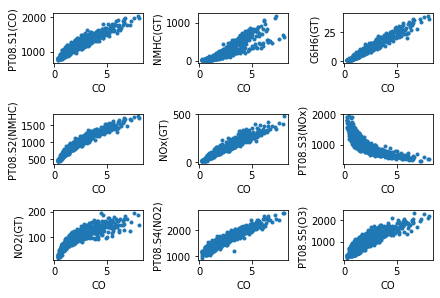

In [ ]:
columnsNumber = len(airQuality.columns)
from math import sqrt
gridSize = int(sqrt(columnsNumber))
fig, ax = plt.subplots(gridSize, gridSize, constrained_layout = True)
i = 0
for column in airQuality:
  if column != "CO(GT)":
    x = int(i/gridSize)
    y = int(i%gridSize)
    ax[x,y].set_xlabel("CO")
    ax[x,y].set_ylabel(column)
    ax[x,y].plot(airQuality["CO(GT)"],airQuality[column],marker=".",linestyle="None")
    i += 1
plt.show()

È evidenziabile una leggera curvatura in alcuni dei grafici appena disegnati; questo ci suggerisce che una regressione polinomiale di grado due possa minimizzare l'errore sui dati, tuttavia per sicurezza creeremo anche un modello di grado uno.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
y = airQuality['CO(GT)']
X = airQuality.drop('CO(GT)',1)
X_train,X_val,y_train,y_val = train_test_split(X, y, train_size=0.7)
lrm = LinearRegression(normalize=True)
lrm.fit(X_train, y_train)
y_pred = lrm.predict(X_val)
print("Errore assoluto: " + str(np.mean((y_pred - y_val)**2)))
print("Errore relativo: "  + str(np.mean(np.abs(y_pred-y_val)/y_val)*100) + " %")
print("Indice R sui dati di addestramento: " + str(lrm.score(X_train, y_train)))
print("Indice R sui dati di validazione: " + str(lrm.score(X_val, y_val)))


Errore assoluto: 0.04649953368733356
Errore relativo: 7.997938419546152%
Indice R sui dati di addestramento: 0.9707178211382188
Indice R sui dati di validazione: + 0.9765650661470069


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
prm = Pipeline([
                ("poly",
                 PolynomialFeatures(degree=2, include_bias=False)),
                ("linreg",LinearRegression())
])
prm.fit(X_train, y_train)
y_pred = prm.predict(X_val)
print("Errore assoluto: " + str(np.mean((y_pred - y_val)**2)))
print("Errore relativo: "  + str(np.mean(np.abs(y_pred-y_val)/y_val)*100) + " %")
print("Indice R sui dati di addestramento: " + str(prm.score(X_train, y_train)))
print("Indice R sui dati di validazione: " + str(prm.score(X_val, y_val)))

Errore assoluto: 0.05261903448648495
Errore relativo: 7.3890592071158405 %
Indice R sui dati di addestramento: 0.9825820047195902
Indice R sui dati di validazione: 0.9734809471232387


## Conclusioni
La differenza fra l'indice R del modello basato su regressione lineare e di quello del modello basato su regressione polinomiale variano nell'ordine dei millesimi, rendendo difficile effettuare una scelta netta. Qualora dovessimo, per una qualche ragione, avere a disposizione solo le colonne PT08.S3, NO2, PT08.S2 e tutte le altre il cui grafico è curvo, allora sceglieremmo la regressione polinomiale; nella casistica opposta sarebbe preferibile la regressione lineare; poichè il nostro modello deve essere il più generico possibile e considerando la similiratà dei risultati dei due modelli, opterei per utilizzare il modello di regressione polinomiale essendo più versatile.